In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yastn
import yastn.tn.mps as mps

from hamiltonians import local_operators, Hamiltonian_dpt_4U_position, Hamiltonian_dpt_4U_momentum, Hamiltonian_dpt_4U_mixed
from auxilliary import merge_mps, merge_mpo, op1site
from hamiltonians import L, S, D, R

In [2]:
NW = 8  #  lattice site is NW + 4 + 1 + NW
NS = 4
mapping = "mixed"  # position, mixed
sym = 'U1'
merge = True

if mapping == "position":
    Hamiltonian = Hamiltonian_dpt_4U_position
    NW1 = NW + 1

    nn = 0 if sym == 'Z2' else NW + NS // 2
    order = 'LDSR'

    if order == 'DLSR':
        sites = [D(1)]  # will have SLR geomery
        sites += [L(k) for k in range(NW, 0, -1)]  # 'L1' is for L mode at the junction
        sites += [S(k) for k in range(1, NS + 1)]  # 'S1' connected to L1
        sites += [R(k) for k in range(1, NW1)]  # 'R1' is for R mode at the junction
    elif order == 'LDSR':
        sites = [L(k) for k in range(NW, 0, -1)]  # 'L1' is for L mode at the junction
        sites += [S(1), S(2), D(1), S(3), S(4)]
        sites += [R(k) for k in range(1, NW1)]  # 'R1' is for R mode at the junction



if mapping == 'mixed':
    Hamiltonian = Hamiltonian_dpt_4U_mixed
    NW1 = NW + 1

    order = 'LRDSLR'

    if order == 'LRDSLR':
        if sym == 'Z2':
            nn = 0
        else:
            nn = (NW + NS // 2) * (1 - np.sin(np.linspace(0, np.pi, 2 * NW + NS + 2)) + 1)
        sites = []
        for k in range(1, NW1):
            sites.append(L(k))
            sites.append(R(k))
        sites = sites[:NW1] + ['S1', 'S2', 'D1', 'S3', 'S4'] + sites[NW1:]
    elif order == 'DLRSLR':
        if sym == 'Z2':
            nn = 0
        else:
            nn = (NW + NS // 2) * (1 - np.sin(np.linspace(0, np.pi, 2 * NW + NS + 2)) + 1)
        sites = []
        for k in range(1, NW1):
            sites.append(L(k))
            sites.append(R(k))
        sites = [D(1)] + sites[:NW1] + ['S1', 'S2', 'S3', 'S4'] + sites[NW1:]

    nn = 0 if sym == 'Z2' else NW + 2

if mapping == 'momentum':
    Hamiltonian = Hamiltonian_dpt_4U_momentum
    NW1 = NW + NS // 2 + 1

    order = 'DLR'
    nn = 0 if sym == 'Z2' else NW + NS // 2

    if order == 'DLR':
        sites = [D(1)]  # will have SLR geomery
        sites += [L(k) for k in range(1, NW + 3)]  # 'L1' is for L mode at the junction
        sites += [R(k) for k in range(1, NW + 3)]  # 'R1' is for R mode at the junction
    elif order == 'LDR':
        sites = []  # will have SLR geomery
        sites += [L(k) for k in range(1, NW + 3)]  # 'L1' is for L mode at the junction
        sites += [D(1)]
        sites += [R(k) for k in range(1, NW + 3)]  # 'R1' is for R mode at the junction


In [3]:
D = 32
U = 3.05
vS = 0.25
alpha = 0.7


H0, s2i, i2s = Hamiltonian(NW, 0, 0, [0, 10000], 0, U * (2 * alpha - 1), sym=sym, order=sites)
qI, qc, qcp, qn, dx, dn1, dn2, dI, m12, m21 = local_operators(sym=sym)

psi = mps.random_mps(H0, n=nn, D_total=D)

H0 = merge_mpo(H0, s2i, merge)
psi = merge_mps(psi, s2i, merge)

opts_svd = {"D_total": D}
info = mps.dmrg_(psi, H0, method='2site', opts_svd=opts_svd, max_sweeps=100, Schmidt_tol=1e-10)
print(info)

O = (np.sqrt(alpha) * dn1 + np.sqrt(1 - alpha) * m12)
O = op1site(O, 'D1', s2i, qI, dI)
O = merge_mpo(O, s2i, merge)

psi = O @ psi
psi.canonize_(to='last')
psi.canonize_(to='first')

On1 = merge_mpo(op1site(dn1, 'D1', s2i, qI, dI), s2i, merge)
On2 = merge_mpo(op1site(dn2, 'D1', s2i, qI, dI), s2i, merge)
Om12 = merge_mpo(op1site(m12, 'D1', s2i, qI, dI), s2i, merge)
Ons = {ss: merge_mpo(op1site(qn, ss, s2i, qI, dI), s2i, merge) for ss in s2i if ss != 'D1'}

print(mps.vdot(psi, On1, psi))
print(mps.vdot(psi, On2, psi))
oo = {ss: mps.vdot(psi, op, psi) for ss, op in Ons.items()}


DMRG_out(sweeps=33, method='2site', energy=-12.476376490704226, denergy=2.6645352591003757e-14, max_dSchmidt=6.629296303644728e-11, max_discarded_weight=np.float64(0.0001292608513527176))
0.7000000000000007
0.29999999999999993


In [4]:
H1, s2i, i2s = Hamiltonian(NW, 0, 0, [0, 0], 0, U, sym=sym, order=sites)
H2, s2i, i2s = Hamiltonian(NW, 0, 0, [0, 0], vS, U, sym=sym, order=sites)

H1 = merge_mpo(H1, s2i, merge)
H2 = merge_mpo(H2, s2i, merge)

dt = 0.06126
tswitch, tfin = 2, 6

times = np.linspace(0, 8, 33)
traces = {'n1': [], 'n2': [], 'm12': [], 'S1': [], 'S2': [], 'S3': [], 'S4': [], 'max_ent': []}
ts = []

for t0, t1, H in [(0, tswitch, H1), (tswitch, tfin, H2)]:
    times = np.linspace(t0, t1, int((t1 - t0) * 4) + 1)
    for step in mps.tdvp_(psi, H, times, method='2site', dt=dt, opts_svd=opts_svd, yield_initial=True):
        print(step)
        ts.append(step.tf)
        traces['n1'].append(mps.vdot(psi, On1, psi).real)
        traces['n2'].append(mps.vdot(psi, On2, psi).real)
        traces['m12'].append(mps.vdot(psi, Om12, psi).real)
        if 'S1' in sites:
            for ind in ['S1', 'S2', 'S3', 'S4']:
                traces[ind].append(mps.vdot(psi, Ons[ind], psi).real)

        ent = psi.get_entropy()
        traces['max_ent'].append(max(ent))


TDVP_out(ti=np.float64(0.0), tf=np.float64(0.0), time_independent=True, dt=0.06126, steps=0)
TDVP_out(ti=np.float64(0.0), tf=np.float64(0.25), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.25), tf=np.float64(0.49999999999999994), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.5), tf=np.float64(0.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.75), tf=np.float64(1.0000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.0), tf=np.float64(1.2500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.25), tf=np.float64(1.5000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.5), tf=np.float64(1.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.75), tf=np.float64(2.0), time_independent=True, dt=np.float64(0.05), step

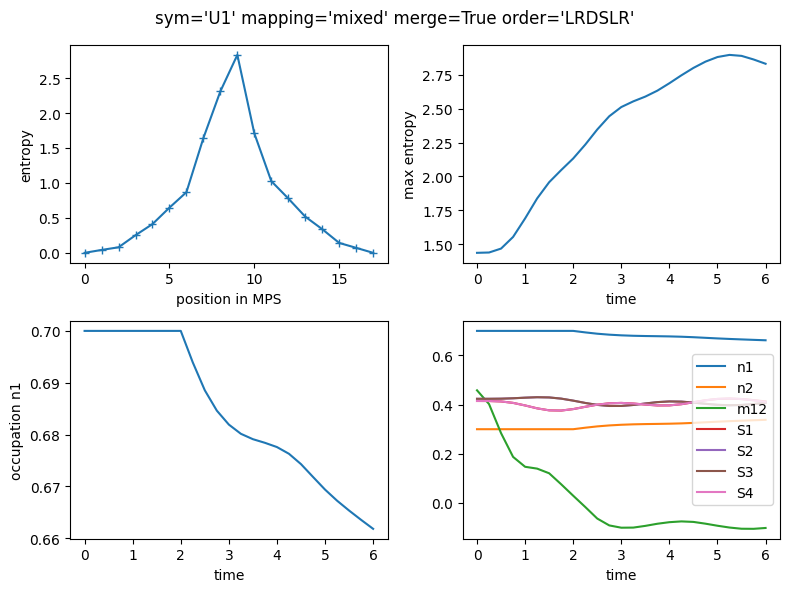

In [5]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 6)
axs[0, 0].plot(psi.get_entropy(), '-+')
axs[0, 0].set_xlabel("position in MPS")
axs[0, 0].set_ylabel("entropy")

axs[0, 1].plot(ts, traces['max_ent'], '-')
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("max entropy")

axs[1, 0].plot(ts, traces['n1'], '-')
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("occupation n1")

for k in ['n1', 'n2', 'm12', 'S1', 'S2', 'S3', 'S4']:
    if k in traces and traces[k]:
        axs[1, 1].plot(ts, traces[k], label=k)
axs[1, 1].legend()
axs[1, 1].set_xlabel("time")

fig.suptitle(f"{sym=} {mapping=} {merge=} {order=}")
fig.tight_layout()